In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import scipy.fftpack
import copy

# Goals of filtering:

Signal/Spectral separation: Isolate distinct sources/frequencies in a signal (noise, signals from different sensors).

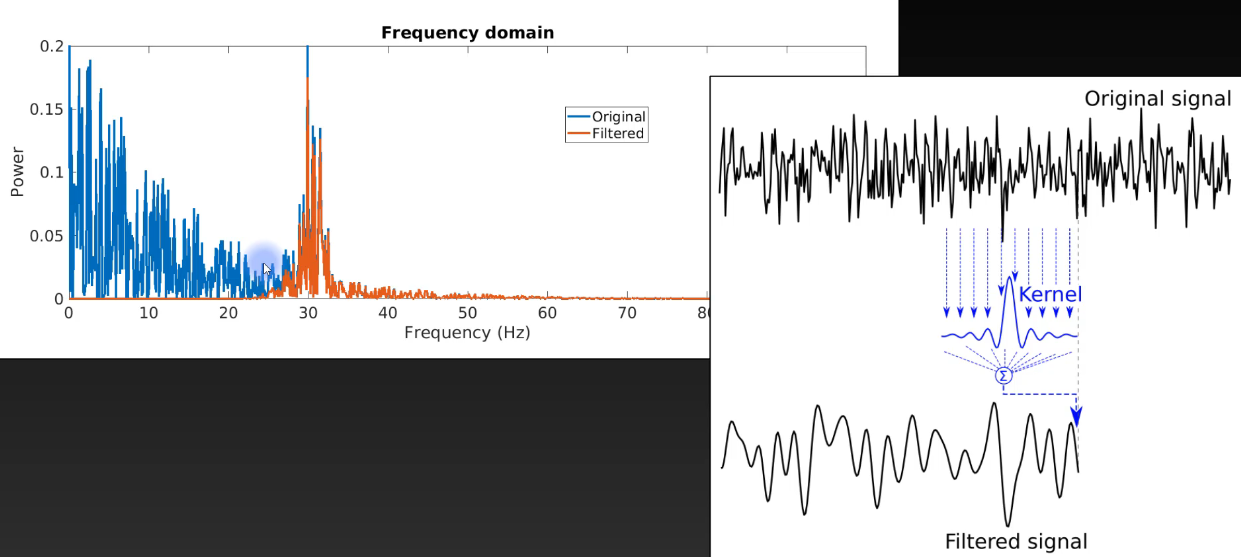

On the freq domain it can be applied with a cutoff on low freq for example in the left image. Then this is ff inverted to a filtered signal. 

On the time domain, filtering can be applied by a kernel (see right image).

These two method actually have the exact same result if the kernel is selected properly.

# Intuition:
- step1: define frequency domain shape and cutoffs
- step2: generate filter kernel (firls, fir1, butter, ...)
- step3: evaluate kernel and its freq spectrum
- step4: apply the filter kernel to the data

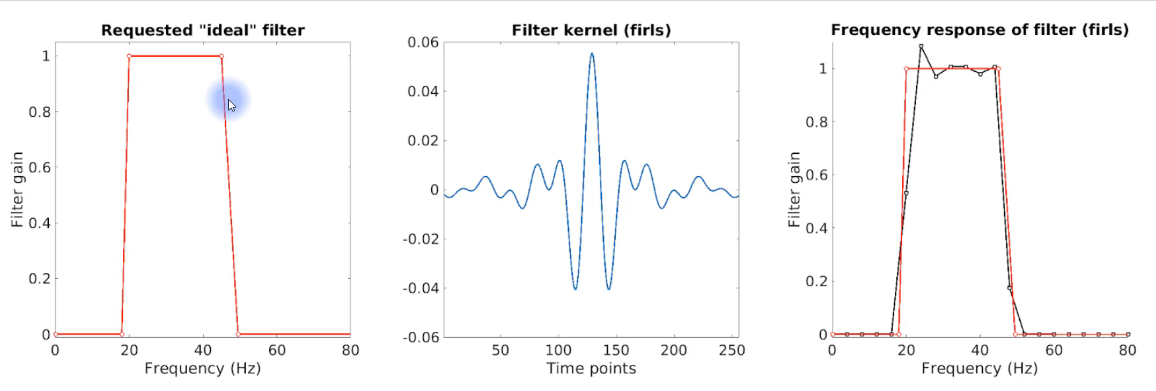

Step 1 define the requested filter, that define your cutoff. Step 2 generate the kernel by inputing your parameter into a funtion that generate the filter kernel. Then apply fft to the kernel to transform it into the freq domain and overlap it with your Requested filter.
It should be as close as possible and there is some trick to make it a better fit.

# Filter types
IIR mechanism: also multiply data with kernel. But also multiply previous result points with kernel.

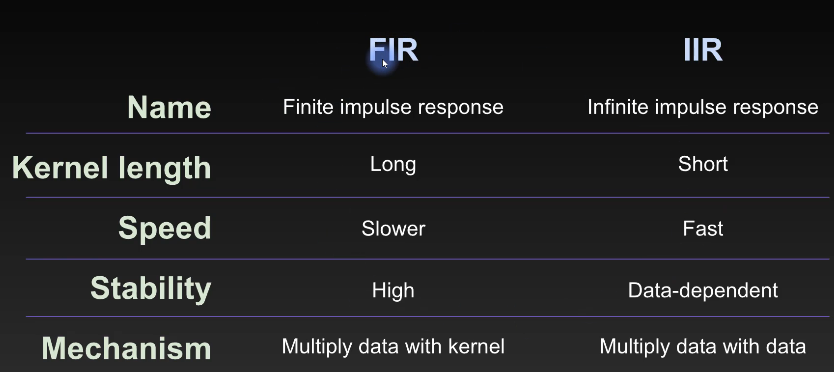



# VIDEO: FIR filters with firls

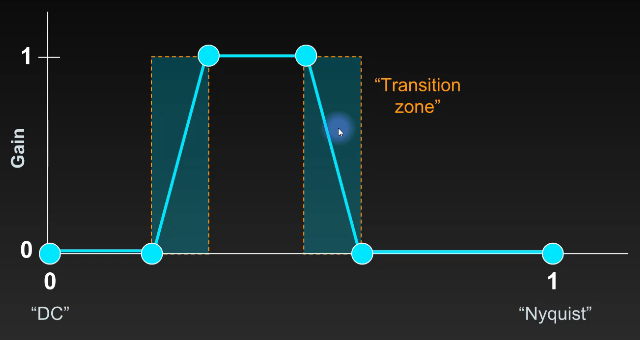

Filters are represented by 6 points.

Increasing the filter order can improve the results

In [47]:
%matplotlib widget

461


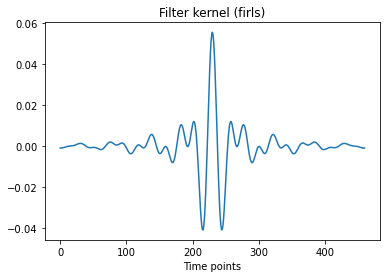

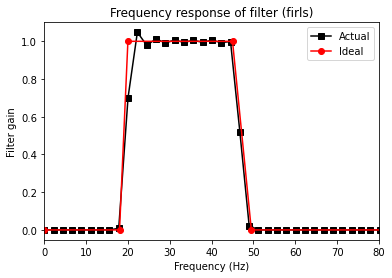

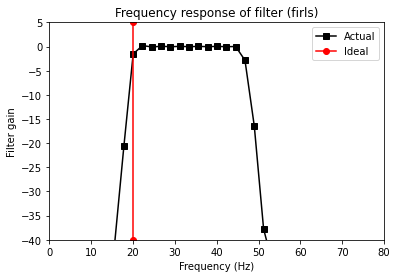

In [29]:
# filter parameters
srate   = 1024 # hz
nyquist = srate/2
frange  = [20,45] # we want to keep freq between 20 and 45
transw  = .1
order   = int(9*srate/frange[0] ) # order is the nb of points in the kernel

# order must be odd
if order%2==0:
    order += 1

# define filter shape
shape = [ 0, 0, 1, 1, 0, 0 ]  # Y axis values
frex  = [ 0, frange[0]-frange[0]*transw, frange[0], frange[1], frange[1]+frange[1]*transw, nyquist ] # x axis

# filter kernel
filtkern = signal.firls(order,frex,shape,fs=srate)
print(len(filtkern))

# time-domain filter kernel
plt.plot(filtkern)
plt.xlabel('Time points')
plt.title('Filter kernel (firls)')
plt.show()



# compute the power spectrum of the filter kernel
filtpow = np.abs(scipy.fftpack.fft(filtkern))**2
# compute the frequencies vector and remove negative frequencies
hz      = np.linspace(0,srate/2,int(np.floor(len(filtkern)/2)+1))
filtpow = filtpow[0:len(hz)]


# plot amplitude spectrum of the filter kernel
plt.plot(hz,filtpow,'ks-',label='Actual')
plt.plot(frex,shape,'ro-',label='Ideal')
plt.xlim([0,frange[0]*4])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.legend()
plt.title('Frequency response of filter (firls)')
plt.show()



# Same as above but logarithmically scaled
plt.plot(hz,10*np.log10(filtpow),'ks-',label='Actual')
plt.plot([frange[0],frange[0]],[-40,5],'ro-',label='Ideal')
plt.xlim([0,frange[0]*4])
plt.ylim([-40,5])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.legend()
plt.title('Frequency response of filter (firls)')
plt.show()




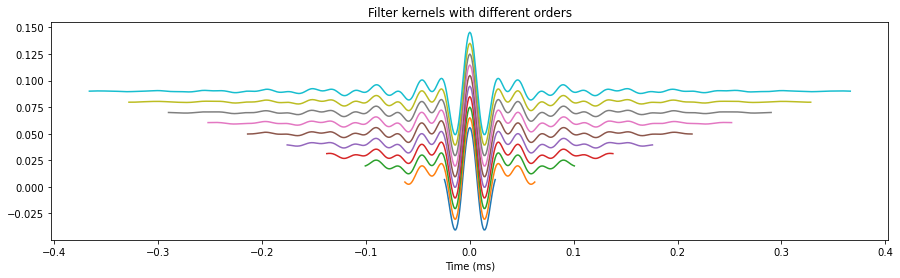

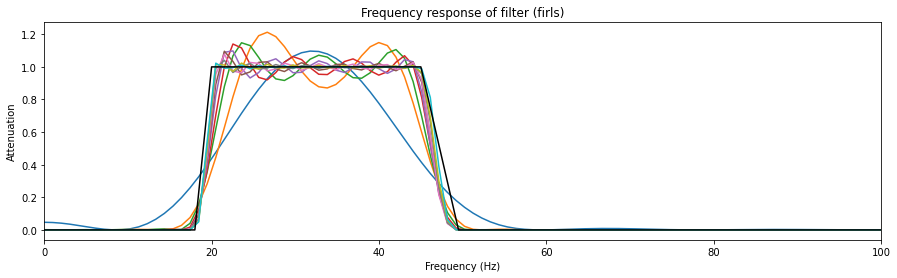

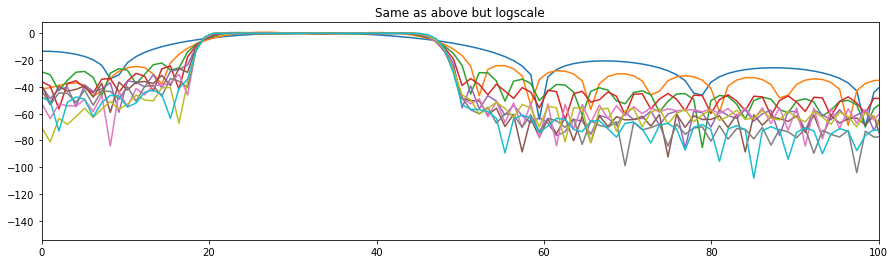

In [22]:
## effects of the filter kernel order
plt.figure(figsize=(15,4))

# range of orders
ordersF = ( 1*srate/frange[0]) / (srate/1000)
ordersL = (15*srate/frange[0]) / (srate/1000)

orders = np.round( np.linspace(ordersF,ordersL,10) )

# initialize
fkernX = np.zeros((len(orders),1000))
hz = np.linspace(0,srate,1000)


for oi in range(0,len(orders)):
    
    # make sure order is odd-length
    ord2use = orders[oi]+(1-orders[oi]%2)
    
    # create filter kernel
    fkern = signal.firls(ord2use,frex,shape,fs=srate)

    # take its FFT
    fkernX[oi,:] = np.abs(scipy.fftpack.fft(fkern,1000))**2
    
    # show in plot
    time = np.arange(0,ord2use)/srate
    time = time - np.mean(time)
    plt.plot(time,fkern+.01*oi)

plt.xlabel('Time (ms)')
plt.title('Filter kernels with different orders')
plt.show()


plt.figure(figsize=(15,4))
plt.plot(hz,fkernX.T)
plt.plot(frex,shape,'k')
plt.xlim([0,100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation')
plt.title('Frequency response of filter (firls)')
plt.show()


plt.figure(figsize=(15,4))
plt.plot(hz,10*np.log10(fkernX.T))
plt.xlim([0,100])
plt.title('Same as above but logscale')
plt.show()

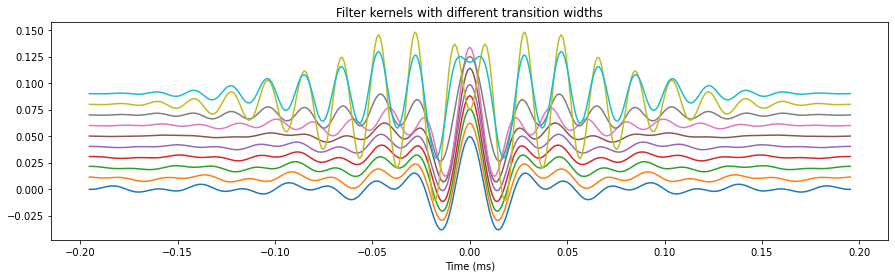

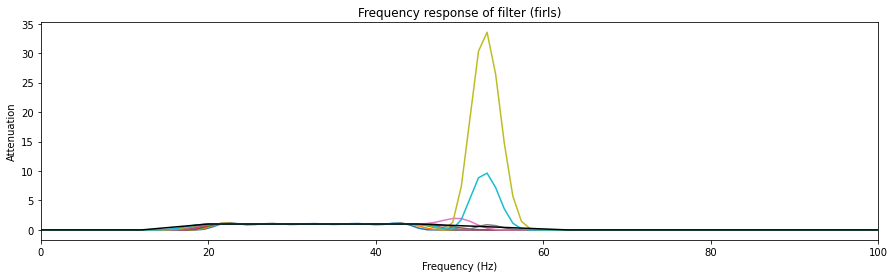

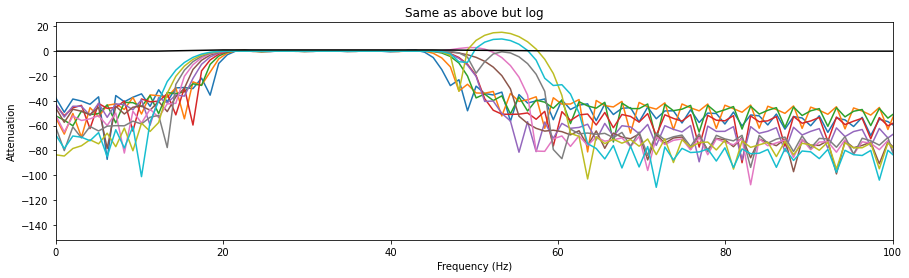

In [25]:
## effects of the filter transition width
plt.figure(figsize=(15,4))
# range of transitions
transwidths = np.linspace(.01,.4,10)

# initialize
fkernX = np.zeros((len(transwidths),1000))
hz = np.linspace(0,srate,1000)

for ti in range(0,len(transwidths)):
    
    # create filter kernel
    frex  = [ 0, frange[0]-frange[0]*transwidths[ti], frange[0], frange[1], frange[1]+frange[1]*transwidths[ti], nyquist ]
    fkern = signal.firls(401,frex,shape,fs=srate)
    n     = len(fkern)

    # take its FFT
    fkernX[ti,:] = np.abs(scipy.fftpack.fft(fkern,1000))**2
    
    # show in plot
    time = np.arange(0,401)/srate
    time = time - np.mean(time)
    plt.plot(time,fkern+.01*ti)

plt.xlabel('Time (ms)')
plt.title('Filter kernels with different transition widths')
plt.show()


plt.figure(figsize=(15,4))
plt.plot(hz,fkernX.T)
plt.plot(frex,shape,'k')
plt.xlim([0,100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation')
plt.title('Frequency response of filter (firls)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(hz,10*np.log10(fkernX.T))
plt.plot(frex,shape,'k')
plt.xlim([0,100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation')
plt.title('Same as above but log')
plt.show()


---
# VIDEO: FIR filters with fir1
---


fir1 you don't specify the transition zone. Just give 4 points. The algo then apply a window to smooth the edges.

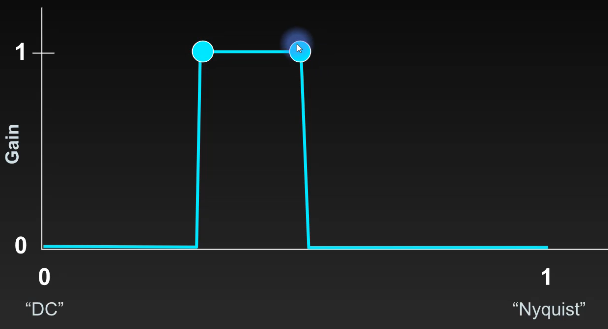

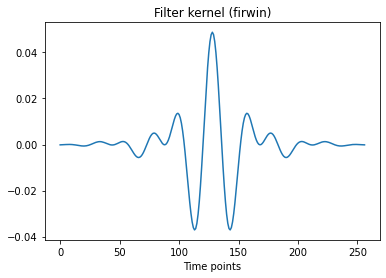

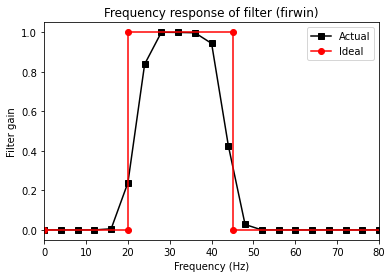

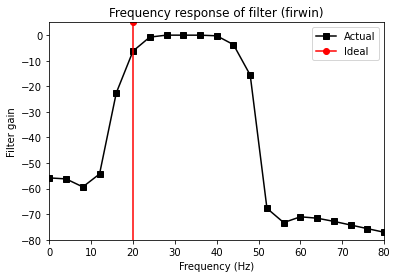

In [30]:
# filter parameters
srate   = 1024 # hz
nyquist = srate/2
frange  = [20,45]
transw  = .1
order   = int( 5*srate/frange[0] )

# force odd order
if order%2==0:
    order += 1

### --- NOTE: Python's firwin corresponds to MATLAB's fir1 --- ###

# filter kernel
filtkern = signal.firwin(order,frange,fs=srate,pass_zero=False)


# time-domain filter kernel
plt.plot(filtkern)
plt.xlabel('Time points')
plt.title('Filter kernel (firwin)')
plt.show()




# compute the power spectrum of the filter kernel
filtpow = np.abs(scipy.fftpack.fft(filtkern))**2
# compute the frequencies vector and remove negative frequencies
hz      = np.linspace(0,srate/2,int(np.floor(len(filtkern)/2)+1))
filtpow = filtpow[0:len(hz)]



# plot amplitude spectrum of the filter kernel
plt.plot(hz,filtpow,'ks-',label='Actual')
plt.plot([0,frange[0],frange[0],frange[1],frange[1],nyquist],[0,0,1,1,0,0],'ro-',label='Ideal')
plt.xlim([0,frange[0]*4])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.legend()
plt.title('Frequency response of filter (firwin)')
plt.show()



# Same as above but logarithmically scaled
plt.plot(hz,10*np.log10(filtpow),'ks-',label='Actual')
plt.plot([frange[0],frange[0]],[-100,5],'ro-',label='Ideal')
plt.xlim([0,frange[0]*4])
plt.ylim([-80,5])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.legend()
plt.title('Frequency response of filter (firwin)')
plt.show()

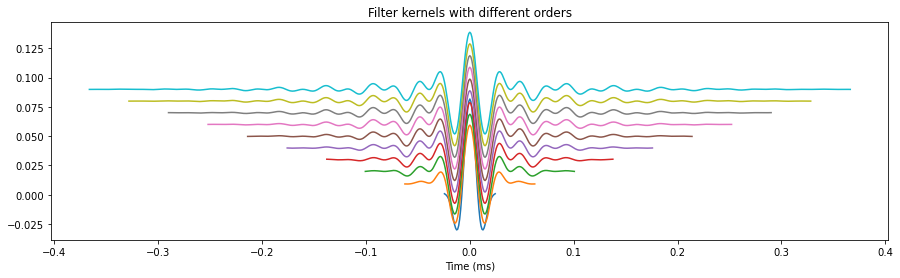

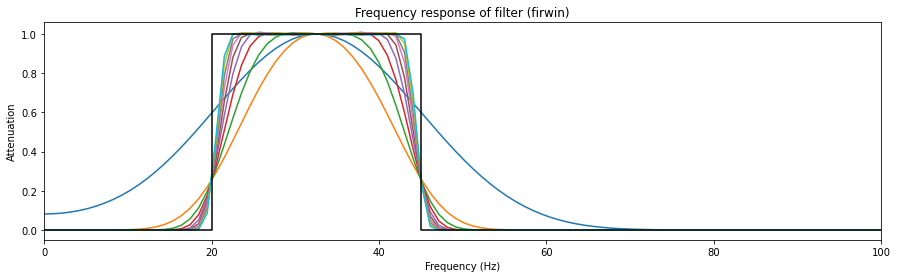

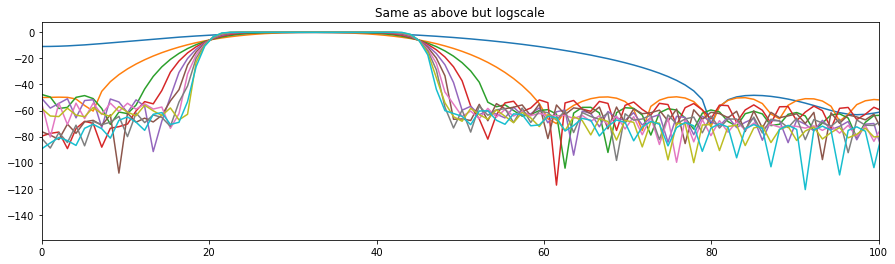

In [32]:
## effects of the filter kernel order
plt.figure(figsize=(15,4))
# range of orders
orders = np.round( np.linspace( (srate/frange[0]) / (srate/1000),(15*srate/frange[0]) / (srate/1000) ,10) )


# initialize
fkernX = np.zeros((len(orders),1000))
hz = np.linspace(0,srate,1000)


for oi in range(0,len(orders)):
    
    # make sure order is odd-length
    ord2use = orders[oi]+(1-orders[oi]%2)
    
    # create filter kernel
    fkern = signal.firwin(int(ord2use),frange,fs=srate,pass_zero=False)

    # take its FFT
    fkernX[oi,:] = np.abs(scipy.fftpack.fft(fkern,1000))**2
    
    # show in plot
    time = np.arange(0,ord2use)/srate
    time = time - np.mean(time)
    plt.plot(time,fkern+.01*oi)

plt.xlabel('Time (ms)')
plt.title('Filter kernels with different orders')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(hz,fkernX.T)
plt.plot([0,frange[0],frange[0],frange[1],frange[1],nyquist],[0,0,1,1,0,0],'k')
plt.xlim([0,100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation')
plt.title('Frequency response of filter (firwin)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(hz,10*np.log10(fkernX.T))
plt.xlim([0,100])
plt.title('Same as above but logscale')
plt.show()

# VIDEO: IIR Butterworth filters

Like in FIR1 just define the low and high pass

To evaluate the IIR filter you don't look the freq domain

IIR filter return 2 values
- B: coefficient to apply to the signal
- A: coefficient to apply to the previous filtered signal points

C:\Users\fabrice.lacout\AppData\Local\Temp\ipykernel_16200\2541725642.py:24: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(hz,filtpow[0:len(hz)],'ks-')


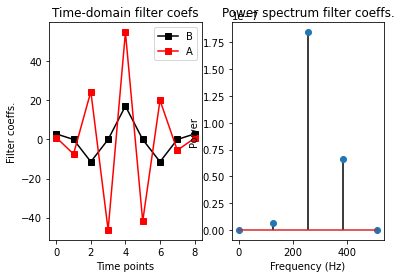

In [33]:

# filter parameters
srate   = 1024 # hz
nyquist = srate/2
frange  = [20,45]

# create filter coefficients
fkernB,fkernA = signal.butter(4,np.array(frange)/nyquist,btype='bandpass') # first argument is the order

# power spectrum of filter coefficients
filtpow = np.abs(scipy.fftpack.fft(fkernB))**2
hz      = np.linspace(0,srate/2,int(np.floor(len(fkernB)/2)+1))


# plotting
plt.subplot(121)
plt.plot(fkernB*1e5,'ks-',label='B')
plt.plot(fkernA,'rs-',label='A')
plt.xlabel('Time points')
plt.ylabel('Filter coeffs.')
plt.title('Time-domain filter coefs')
plt.legend()

plt.subplot(122)
plt.stem(hz,filtpow[0:len(hz)],'ks-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power spectrum filter coeffs.')
plt.show()


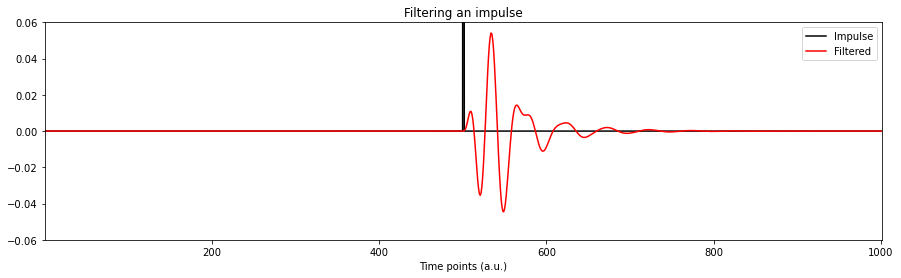

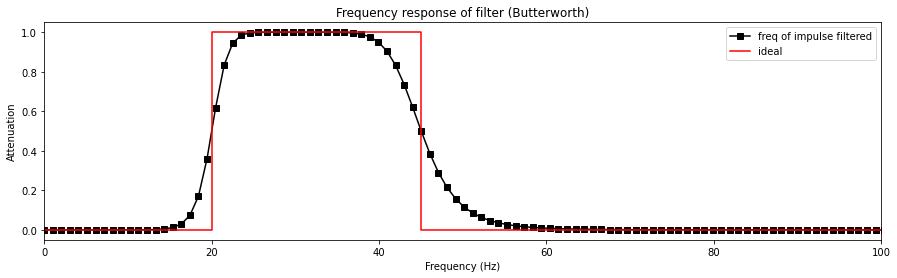

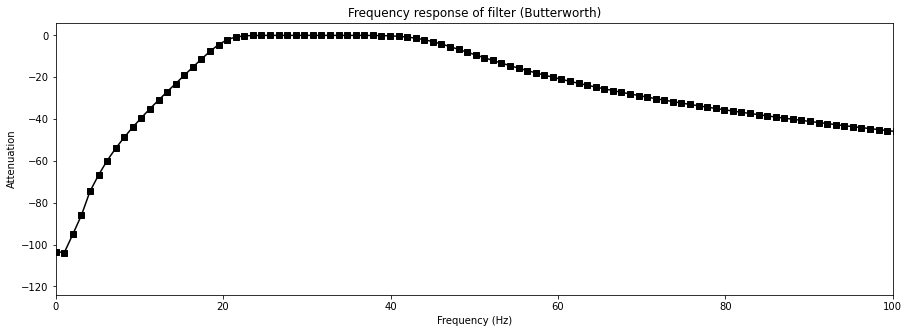

In [37]:
## how to evaluate an IIR filter: filter an impulse

# generate the impulse
impres = np.zeros(1001)
impres[501] = 1

# apply the filter
fimp = signal.lfilter(fkernB,fkernA,impres,axis=-1)

# compute power spectrum
fimpX = np.abs(scipy.fftpack.fft(fimp))**2
hz = np.linspace(0,nyquist,int(np.floor(len(impres)/2)+1))


# plot
plt.figure(figsize=(15,4))
plt.plot(impres,'k',label='Impulse')
plt.plot(fimp,'r',label='Filtered')
plt.xlim([1,len(impres)])
plt.ylim([-.06,.06])
plt.legend()
plt.xlabel('Time points (a.u.)')
plt.title('Filtering an impulse')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(hz,fimpX[0:len(hz)],'ks-', label='freq of impulse filtered')
plt.plot([0,frange[0],frange[0],frange[1],frange[1],nyquist],[0,0,1,1,0,0],'r', label='ideal')
plt.xlim([0,100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation')
plt.title('Frequency response of filter (Butterworth)')
plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.plot(hz,10*np.log10(fimpX[0:len(hz)]),'ks-')
plt.xlim([0,100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation')
plt.title('Frequency response of filter (Butterworth)')
plt.show()

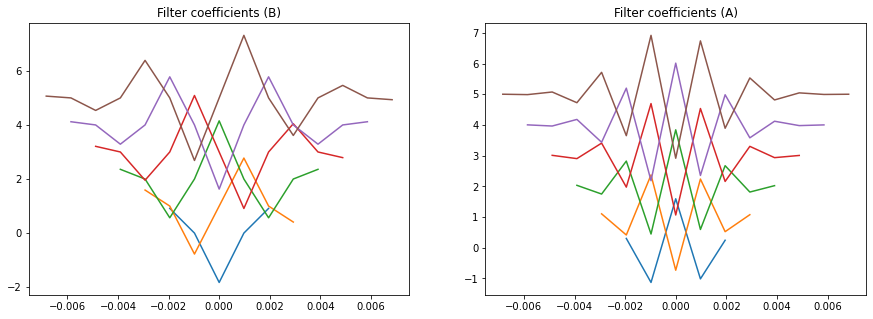

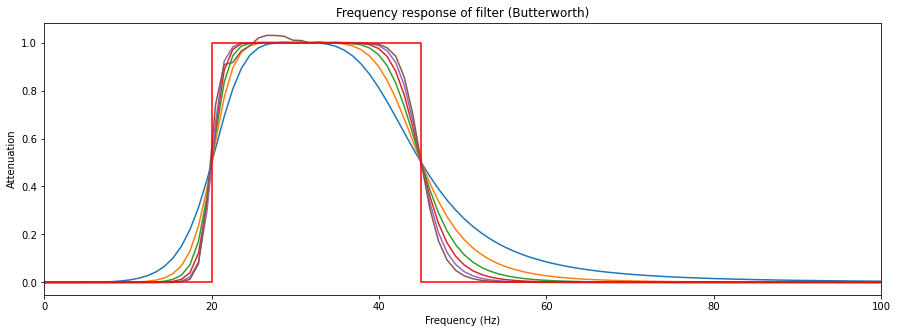

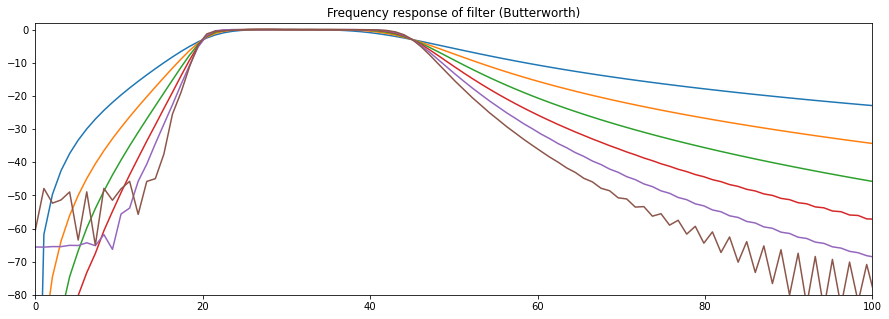

In [38]:
## effects of order parameter

orders = range(2,8)

fkernX = np.zeros((len(orders),1001))
hz = np.linspace(0,srate,1001)

plt.figure(figsize=(15,5))
# loop over orders
for oi in range(0,len(orders)):
    
    # create filter kernel
    fkernB,fkernA = signal.butter(orders[oi],np.array(frange)/nyquist,btype='bandpass')
    n = len(fkernB)
    
    # filter the impulse response and take its power
    fimp = signal.lfilter(fkernB,fkernA,impres,axis=-1)
    fkernX[oi,:] = np.abs(scipy.fftpack.fft(fimp))**2
    
    
    # show in plot
    time = np.arange(0,len(fkernB))/srate
    time = time - np.mean(time)
    plt.subplot(121)
    plt.plot(time,scipy.stats.zscore(fkernB)+oi)
    plt.title('Filter coefficients (B)')
    
    plt.subplot(122)
    plt.plot(time,scipy.stats.zscore(fkernA)+oi)
    plt.title('Filter coefficients (A)')

plt.show()


# plot the spectra
plt.figure(figsize=(15,5))
plt.plot(hz,fkernX.T)
plt.plot([0,frange[0],frange[0],frange[1],frange[1],nyquist],[0,0,1,1,0,0],'r')
plt.xlim([0,100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation')
plt.title('Frequency response of filter (Butterworth)')
plt.show()


# in log space
plt.figure(figsize=(15,5))
plt.plot(hz,10*np.log10(fkernX.T))
plt.xlim([0,100])
plt.ylim([-80,2])
plt.title('Frequency response of filter (Butterworth)')
plt.show()


---
# VIDEO: Causal and zero-phase-shift filters
---

Casual filter is also called forward filtered. The filtered point is calculated from PREVIOUS points in the signal

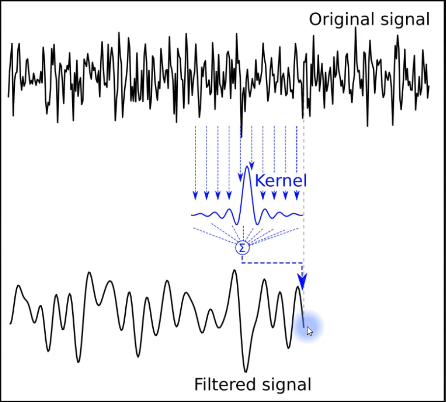

In zero phase you first calculate the filtered signal like in forward.

Then you do a second pass where you flip the filtered-signal in time and repeat the filtered calculation on it.

Finally you flip this output (double filtered) to get your final filtering.

The result is said zero phase shift because there is no time shift in the output.

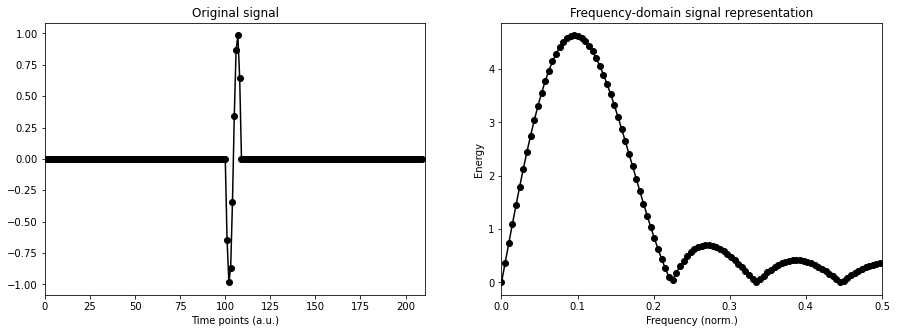

In [2]:
# create a simple signal
data = np.concatenate((np.zeros(100),np.cos(np.linspace(np.pi/2,5*np.pi/2,10)),np.zeros(100)),axis=0)
n = len(data)

# plot it and its power spectrum
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(range(0,n),data,'ko-')
plt.xlim([0,n+1])
plt.title('Original signal')
plt.xlabel('Time points (a.u.)')

plt.subplot(122)
plt.plot(np.linspace(0,1,n),np.abs(scipy.fftpack.fft(data)),'ko-')
plt.xlim([0,0.5])
plt.xlabel('Frequency (norm.)')
plt.ylabel('Energy')
plt.title('Frequency-domain signal representation')
plt.show()

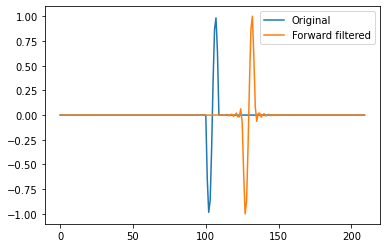

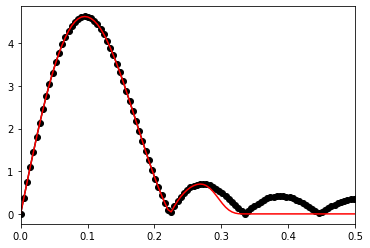

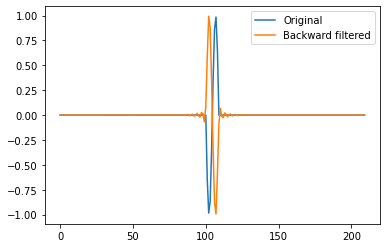

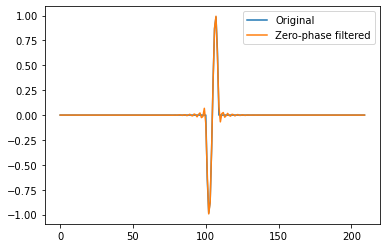

In [3]:
## apply a low-pass causal filter

# note: frequency listed as fraction of Nyquist (not sampling rate!)
fkern = signal.firwin(51,.6) # 51 is the order, 0.6 is the freq cutoff (BUT it's 0.6 of Nyquist)
fdata = signal.lfilter(fkern,1,data)
plt.plot(range(0,n),data,label='Original')
plt.plot(range(0,n),fdata,label='Forward filtered')
plt.legend()
plt.show()

# flip the signal backwards
fdataFlip = fdata[::-1]
# and show its spectrum
plt.plot(np.linspace(0,1,n),np.abs(scipy.fftpack.fft(data)),'ko-')
plt.plot(np.linspace(0,1,n),np.abs(scipy.fftpack.fft(fdataFlip)),'r')
plt.xlim([0,.5])
plt.show()


# filter the flipped signal
fdataF = signal.lfilter(fkern,1,fdataFlip)
plt.plot(range(0,n),data,label='Original')
plt.plot(range(0,n),fdataF,label='Backward filtered')
plt.legend()
plt.show()

# finally, flip the double-filtered signal
fdataF = fdataF[::-1]
plt.plot(range(0,n),data,label='Original')
plt.plot(range(0,n),fdataF,label='Zero-phase filtered')
plt.legend()
plt.show()



---
# VIDEO: Avoid edge effects with reflection
---

Problem: the kernel start calculation a signal[len(kernel)] because it looks at previous points.

To solve we padd the signla to left and right by the len(signal). We don't pad with zeros, but with the signal itself that is mirrored. See image below:

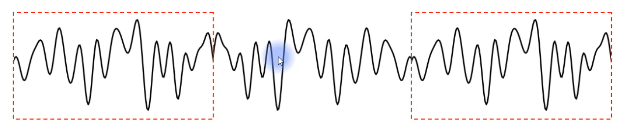

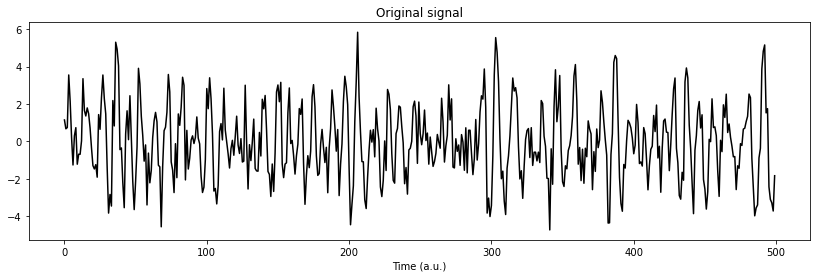

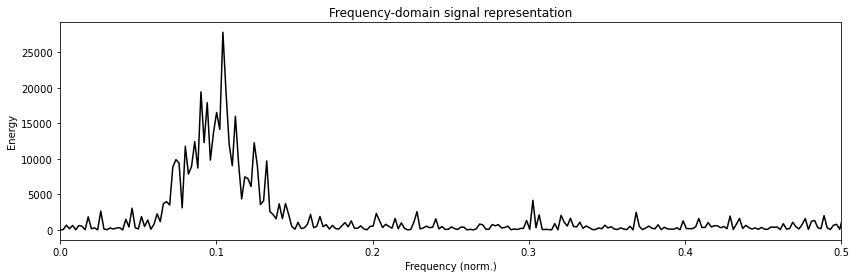

In [11]:
# create a signal
N  = 500
hz = np.linspace(0,1,N)
gx = np.exp( -(4*np.log(2)*(hz-.1)/.1)**2 )*N/2
data = np.real(scipy.fftpack.ifft( gx*np.exp(1j*np.random.rand(N)*2*np.pi) ))
data = data + np.random.randn(N)

plt.figure(figsize=(14,4))
# plot it and its power spectrum
plt.plot(range(0,N),data,'k')
plt.title('Original signal')
plt.xlabel('Time (a.u.)')
plt.show()

plt.figure(figsize=(14,4))
plt.plot(hz,np.abs(scipy.fftpack.fft(data))**2,'k')
plt.xlim([0,.5])
plt.xlabel('Frequency (norm.)')
plt.ylabel('Energy')
plt.title('Frequency-domain signal representation')
plt.show()

151


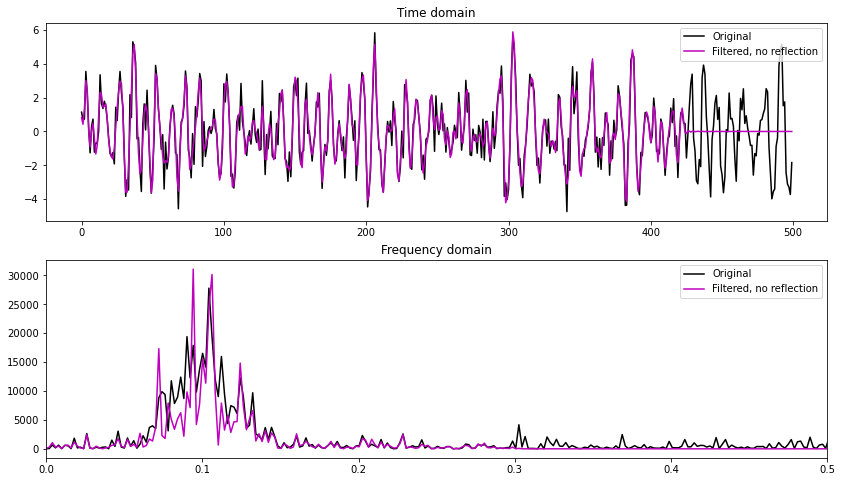

In [16]:
## apply a low-pass causal filter to SEE the EDGE EFFECT on the signal filtered

# generate filter kernel
order = 151
fkern = signal.firwin(order,.6) # filter cut above 0.6 of Nyquist, so around 0.3 hz
print(len(fkern))

# zero-phase-shift filter
fdata = signal.lfilter(fkern,1,data) # forward
fdata = signal.lfilter(fkern,1,np.flip(fdata,0)) # reverse
fdata = np.flip(fdata,0) # flip forward


plt.figure(figsize=(14,8))
# plot the original signal and filtered version
plt.subplot(211)
plt.plot(range(0,N),data,'k',label='Original')
plt.plot(range(0,N),fdata,'m',label='Filtered, no reflection')
plt.title('Time domain')
plt.legend()


# power spectra
plt.subplot(212)
plt.plot(hz,np.abs(scipy.fftpack.fft(data))**2,'k',label='Original')
plt.plot(hz,np.abs(scipy.fftpack.fft(fdata))**2,'m',label='Filtered, no reflection')
plt.title('Frequency domain')
plt.xlim([0,.5])
plt.legend()
plt.show()

# ALSO THE Frequency domain is ALTERED because of the edge effect in the signal

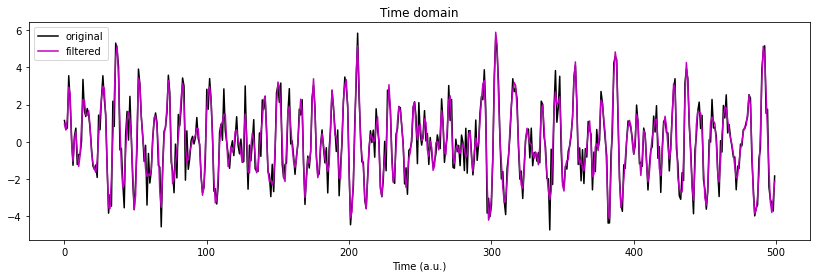

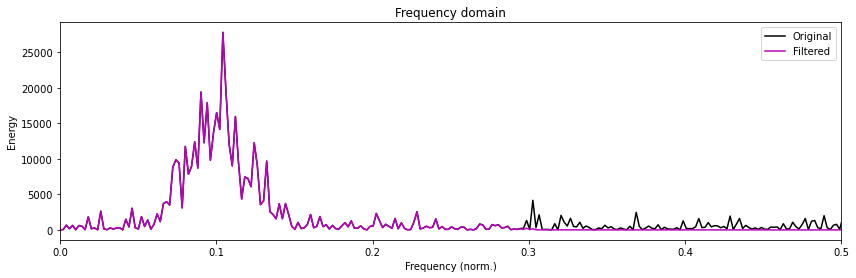

In [19]:
## now with reflection by filter order

# reflect the signal
reflectdata = np.concatenate( (data[order:0:-1],data,data[-1:-1-order:-1]) ,axis=0)

# zero-phase-shift filter on the reflected signal
reflectdata = signal.lfilter(fkern,1,reflectdata)
reflectdata = signal.lfilter(fkern,1,reflectdata[::-1])
reflectdata = reflectdata[::-1]

# now chop off the reflected parts
fdata = reflectdata[order:-order]

# try again with filtfilt
#fdata1 = signal.filtfilt(fkern,1,data)

plt.figure(figsize=(14,4))
# and plot
plt.plot(range(0,N),data,'k',label='original')
plt.plot(range(0,N),fdata,'m',label='filtered')
# plt.plot(range(0,N),fdata1,'b',label='filtered1')
plt.xlabel('Time (a.u.)')
plt.title('Time domain')
plt.legend()
plt.show()

plt.figure(figsize=(14,4))
# spectra
plt.plot(hz,np.abs(scipy.fftpack.fft(data))**2,'k',label='Original')
plt.plot(hz,np.abs(scipy.fftpack.fft(fdata))**2,'m',label='Filtered')
plt.legend()
plt.xlim([0,.5])
plt.xlabel('Frequency (norm.)')
plt.ylabel('Energy')
plt.title('Frequency domain')
plt.show()

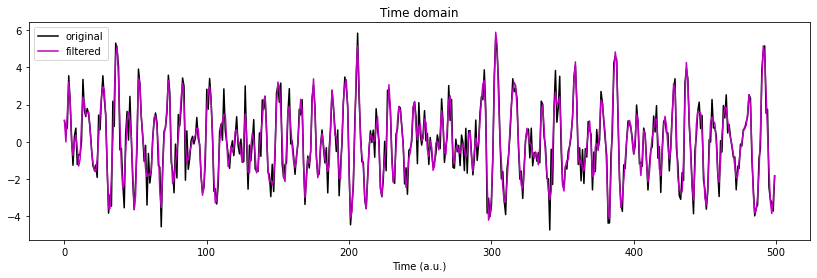

In [20]:
# try again with filtfilt, it does the same thing!
# filtfilt does reflection on the signal, then apply the given filter with zero phase shift
fdata1 = signal.filtfilt(fkern,1,data)

plt.figure(figsize=(14,4))
# and plot
plt.plot(range(0,N),data,'k',label='original')
plt.plot(range(0,N),fdata1,'m',label='filtered')
plt.xlabel('Time (a.u.)')
plt.title('Time domain')
plt.legend()
plt.show()


---
# VIDEO: Data length and filter kernel length
---

An error happens sometimes with filter almost as long as the signal.
The signal needs to be at least 3x longer than the len(kernel)

To solve this you can reflect the signal

In [26]:
# parameters
dataN = 10000
filtN = 5001

# generate data
signal1 = np.random.randn(dataN)

# create filter kernel
fkern = signal.firwin( filtN,.01,pass_zero=True )

# apply filter kernel to data
fdata = signal.filtfilt(fkern,1,signal1)

ValueError: The length of the input vector x must be greater than padlen, which is 15003.

In [27]:
# reflect the signal
signalRefl = np.concatenate( (signal1[::-1],signal1,signal1[::-1]),axis=0 )

# apply filter kernel to data
fdataR = signal.filtfilt(fkern,1,signalRefl)

# and cut off edges
fdata = fdataR[dataN:-dataN]



---
# VIDEO: Low-pass filters
---

Low pass mean we let the low hz pass. So we cut above a freq

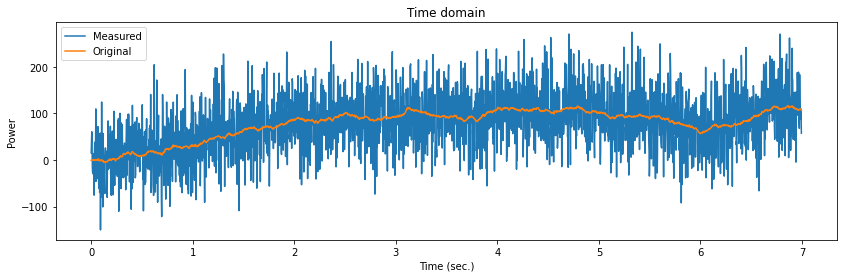

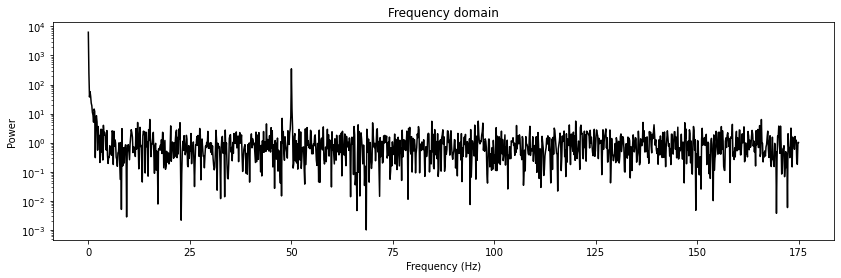

In [34]:
# simulation parameters
fs      = 350 # hz
timevec = np.arange(0,fs*7-1)/fs
npnts   = len(timevec)

# generate signal
yOrig = np.cumsum(np.random.randn(npnts)) # this make the spectrum increase at low frequency
y     = yOrig + 50*np.random.randn(npnts) + 40*np.sin(2*np.pi*50*timevec)  # add a spyke at 50hz

# power spectrum of signal
yX = np.abs(scipy.fftpack.fft(y)/npnts)**2
hz = np.linspace(0,fs/2,int(np.floor(npnts/2)+1))


plt.figure(figsize=(14,4))
# plot the data
plt.plot(timevec,y,label='Measured')
plt.plot(timevec,yOrig,label='Original')
plt.xlabel('Time (sec.)')
plt.ylabel('Power')
plt.title('Time domain')
plt.legend()
plt.show()

plt.figure(figsize=(14,4))
# plot its power spectrum
plt.plot(hz,yX[0:len(hz)],'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Frequency domain')
plt.yscale('log')  # you can also visualize without log scale
plt.show()

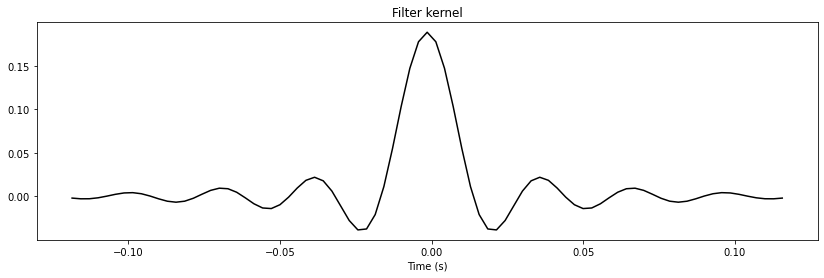

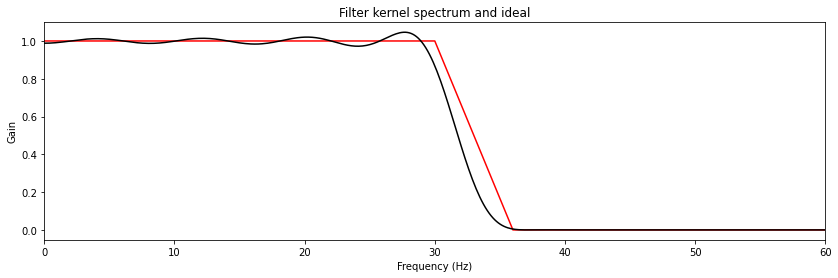

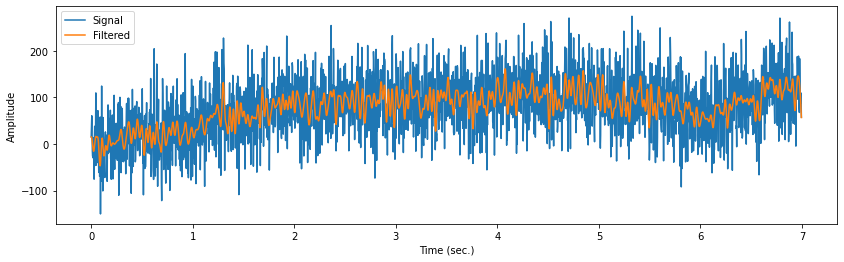

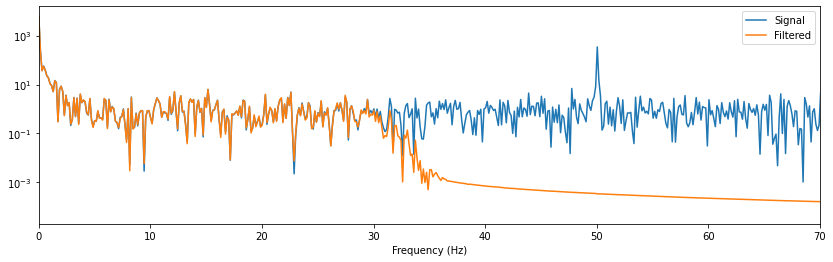

In [39]:
## now for lowpass filter

fcutoff = 30
transw  = .2
order   = np.round( 7*fs/fcutoff )+1

shape   = [ 1,1,0,0 ]
frex    = [ 0, fcutoff, fcutoff+fcutoff*transw, fs/2 ]

# filter kernel
filtkern = signal.firls(order,frex,shape,fs=fs)

# its power spectrum
filtkernX = np.abs(scipy.fftpack.fft(filtkern,npnts))**2


plt.figure(figsize=(14,4))
plt.plot(np.arange(-order/2,order/2)/fs,filtkern,'k')
plt.xlabel('Time (s)')
plt.title('Filter kernel')
plt.show()

plt.figure(figsize=(14,4))
plt.plot(np.array(frex),shape,'r')
plt.plot(hz,filtkernX[:len(hz)],'k')
plt.xlim([0,60])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Filter kernel spectrum and ideal')
plt.show()


########################################################################################
### now apply the filter to the data
yFilt = signal.filtfilt(filtkern,1,y)

plt.figure(figsize=(14,4))
plt.plot(timevec,y,label='Signal')
plt.plot(timevec,yFilt,label='Filtered')
plt.legend()
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.show()

### power spectra of original and filtered signal
yOrigX = np.abs(scipy.fftpack.fft(y)/npnts)**2
yFiltX = np.abs(scipy.fftpack.fft(yFilt)/npnts)**2

plt.figure(figsize=(14,4))
plt.plot(hz,yOrigX[:len(hz)],label='Signal')
plt.plot(hz,yFiltX[:len(hz)],label='Filtered')
plt.xlim([0,fs/5])
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.show()


---
# VIDEO: Windowed-sinc filters
---


This is a type of low pass filter.


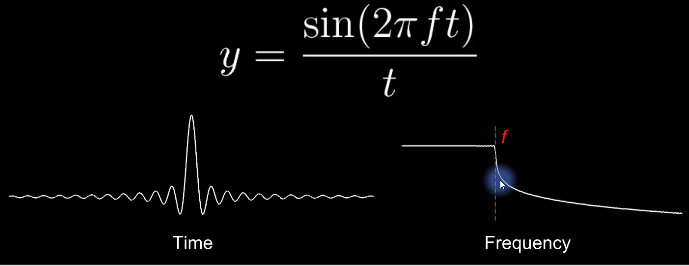

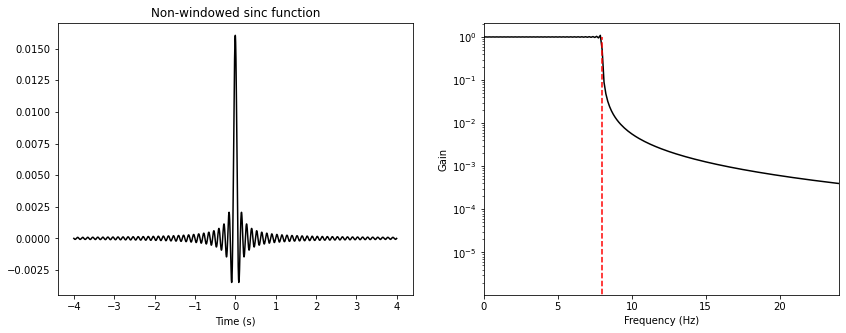

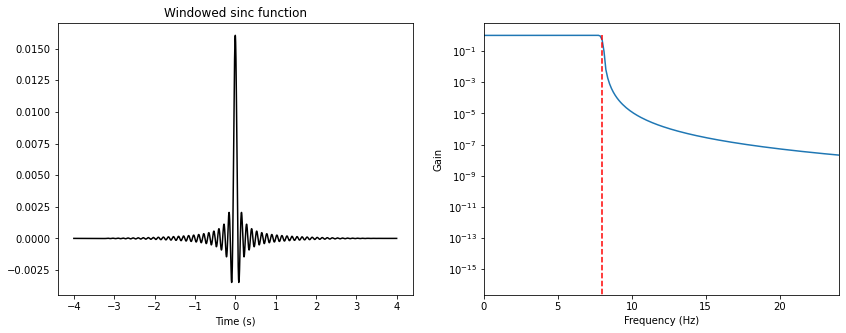

In [50]:
# simulation params
srate = 1000
time  = np.arange(-4,4,1/srate)
pnts  = len(time)

# create sinc function
f = 8
sincfilt = np.sin(2*np.pi*f*time) / time # will divide by 0 and produce a NaN

# adjust NaN and normalize filter to unit-gain
sincfilt[~np.isfinite(sincfilt)] = np.max(sincfilt)  # isinfinite return True for Nan
sincfilt = sincfilt/np.sum(sincfilt)

# windowed sinc filter
sincfiltW = sincfilt * np.hanning(pnts) # hanning generate the han window.


plt.figure(figsize=(14,5))
# plot the sinc filter
plt.subplot(121)
plt.plot(time,sincfilt,'k')
plt.xlabel('Time (s)')
plt.title('Non-windowed sinc function')


# plot the power spectrum
plt.subplot(122)
hz = np.linspace(0,srate/2,int(np.floor(pnts/2)+1))
pw = np.abs(scipy.fftpack.fft(sincfilt))
plt.plot(hz,pw[:len(hz)],'k')
plt.xlim([0,f*3])
plt.yscale('log')
plt.plot([f,f],[0,1],'r--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.show()


plt.figure(figsize=(14,5))
# now plot the windowed sinc filter
plt.subplot(121)
plt.plot(time,sincfiltW,'k')
plt.xlabel('Time (s)')
plt.title('Windowed sinc function')

plt.subplot(122)
pw = np.abs(scipy.fftpack.fft(sincfiltW))
plt.plot(hz,pw[:len(hz)])
plt.xlim([0,f*3])
plt.yscale('log')
plt.plot([f,f],[0,1],'r--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.show()


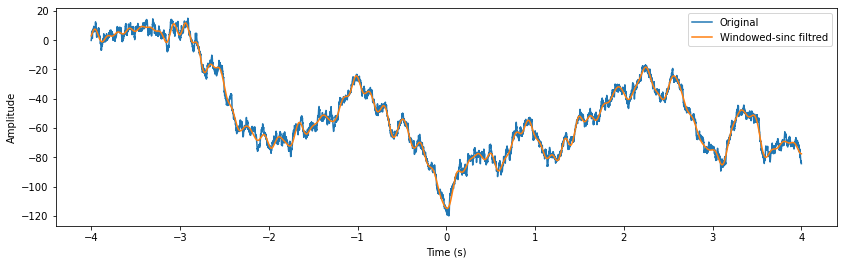

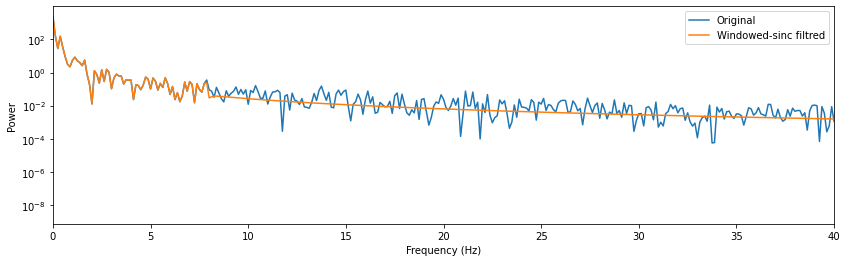

In [46]:
## apply the filter to noise

# generate data as integrated noise
data = np.cumsum( np.random.randn(pnts) )

# reflection
datacat = np.concatenate( (data,data[::-1]) ,axis=0)

# apply filter (zero-phase-shift)
dataf = signal.lfilter(sincfiltW,1,datacat)
dataf = signal.lfilter(sincfiltW,1,dataf[::-1])

# flip forwards and remove reflected points
dataf = dataf[-1:pnts-1:-1]

# compute spectra of original and filtered signals
powOrig = np.abs(scipy.fftpack.fft(data)/pnts)**2
powFilt = np.abs(scipy.fftpack.fft(dataf)/pnts)**2


plt.figure(figsize=(14,4))
# plot
plt.plot(time,data,label='Original')
plt.plot(time,dataf,label='Windowed-sinc filtred')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


plt.figure(figsize=(14,4))
# plot original and filtered spectra
plt.plot(hz,powOrig[:len(hz)],label='Original')
plt.plot(hz,powFilt[:len(hz)],label='Windowed-sinc filtred')
plt.xlim([0,40])
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()

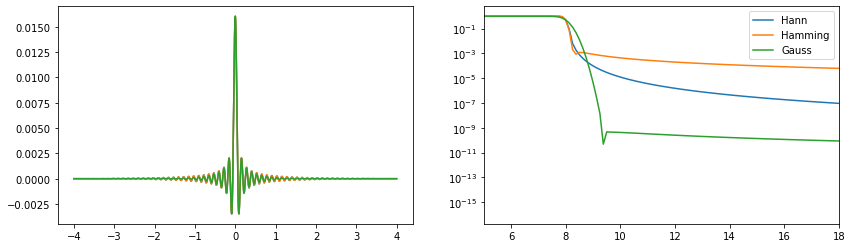

In [47]:
## with different windowing functions

sincfiltW = np.zeros((3,pnts))

tapernames = ['Hann','Hamming','Gauss']

# with Hann taper
# sincfiltW[0,:] = sincfilt * np.hanning(pnts)
hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,pnts))/2
sincfiltW[0,:] = sincfilt * hannw


# with Hamming taper
#sincfiltW[1,:] = sincfilt * np.hamming(pnts)
hammingw = .54 - .46*np.cos(2*np.pi*np.linspace(0,1,pnts))
sincfiltW[1,:] = sincfilt * hammingw


# with Gaussian taper
sincfiltW[2,:] = sincfilt * np.exp(-time**2)



# plot them
plt.figure(figsize=(14,4))
for filti in range(0,len(sincfiltW)):
    plt.subplot(121)
    plt.plot(time,sincfiltW[filti,:])
    
    plt.subplot(122)
    pw = np.abs(scipy.fftpack.fft(sincfiltW[filti,:]))
    plt.plot(hz,pw[:len(hz)],label=tapernames[filti])
    plt.xlim([f-3,f+10])
    plt.yscale('log')
    

plt.legend()
plt.show()